# This notebook is to evaluate network performance on test shots

In [1]:
# imports
from scipy.io import loadmat
import os
from os.path import join

In [2]:
# let's first see what shots we have
SHOTS_DIR = 'test_shots'
SHOTS_NET_DIR = 'test_shots_net'
os.makedirs(SHOTS_NET_DIR, exist_ok=True)

# list all the files inside
SHOT_FILES = os.listdir(SHOTS_DIR)
SHOT_NAMES = [f.split('.')[0] for f in SHOT_FILES if f.endswith('.mat')]
print(f'Found {len(SHOT_NAMES)} shots: {SHOT_NAMES}')

Found 4 shots: ['79742', '78893', '83848', '86310']


In [3]:
# # run matlab inference on each shot
# for s, sn in zip(SHOT_FILES, SHOT_NAMES):
#     print(f'Running matlab inference on {s}...')
#     command = f'matlab -nosplash -nodesktop -r "run_net_on_shot({sn}, \'{SHOTS_NET_DIR}\'); exit;"'
#     os.system(command)

Running JOBID: local, on cpu


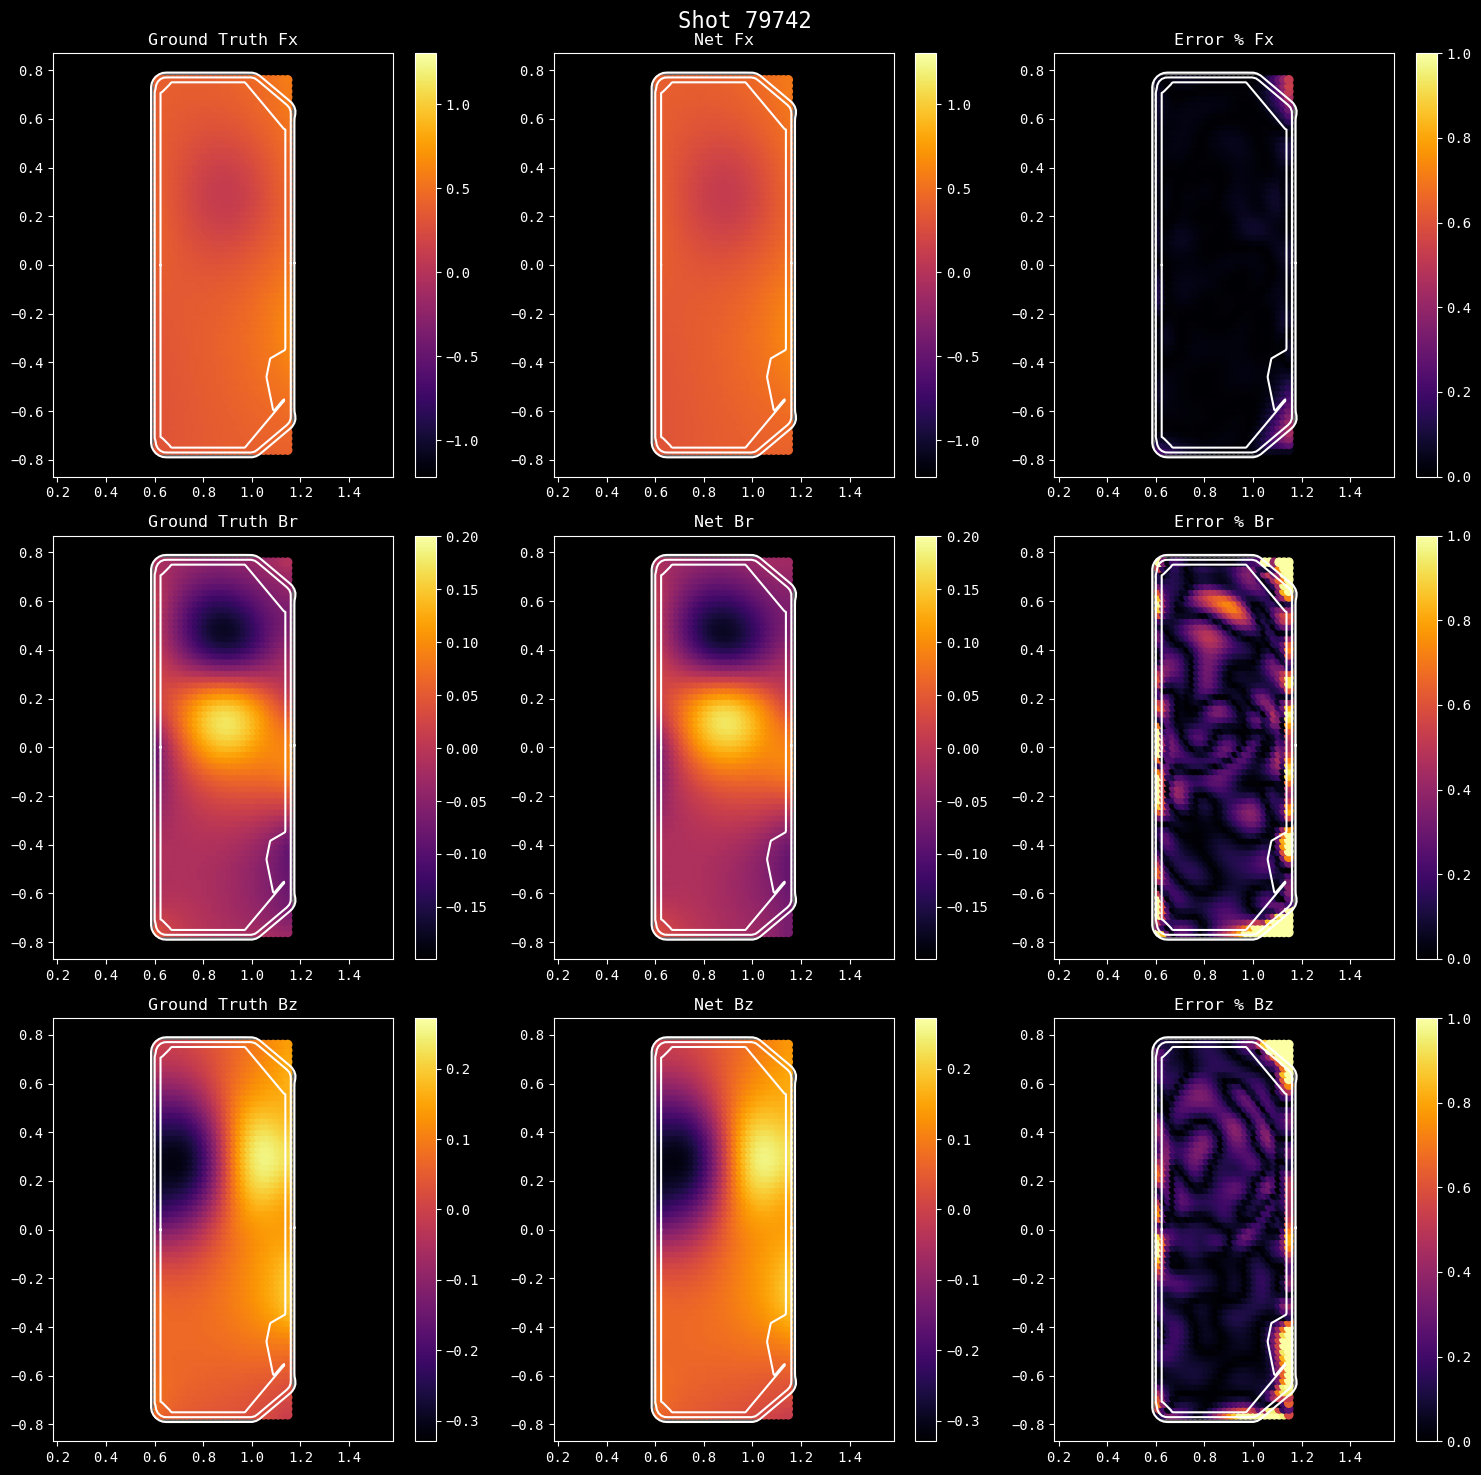

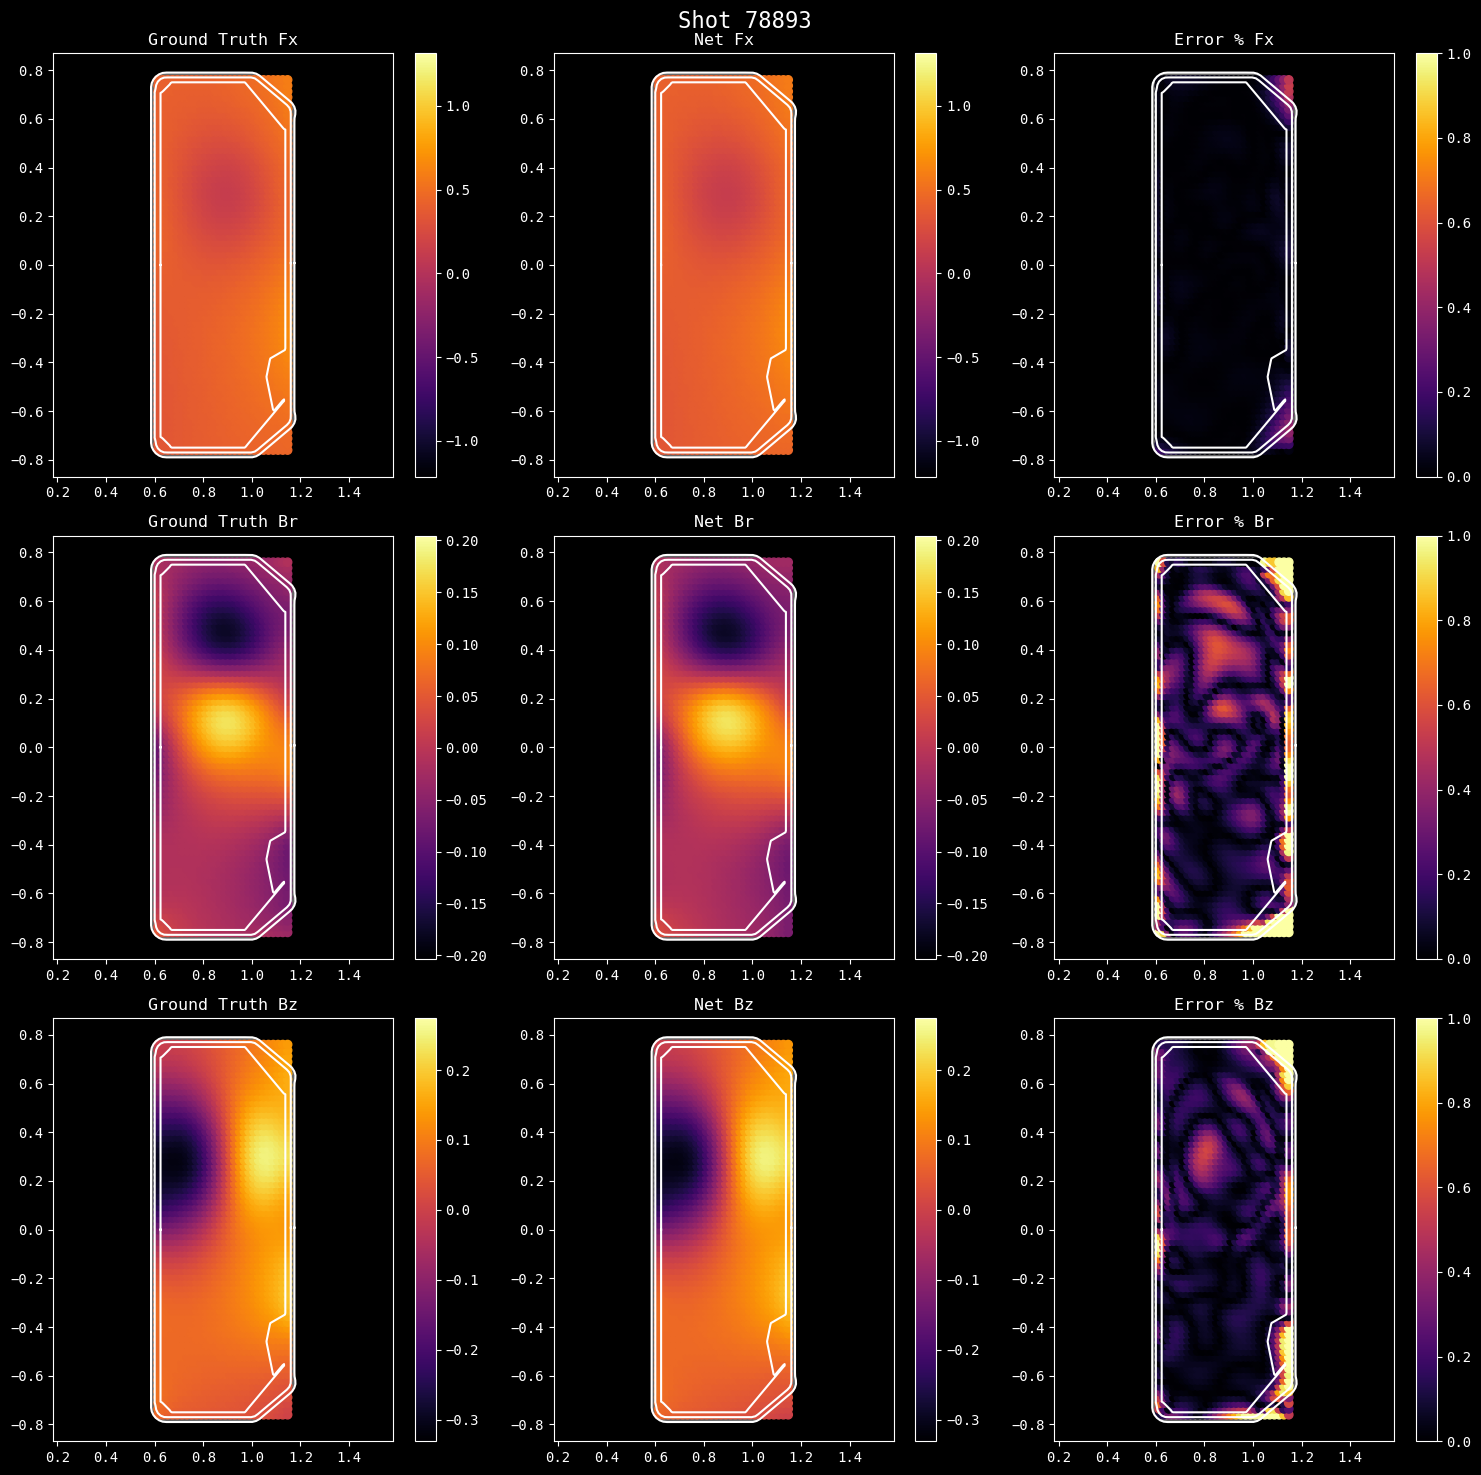

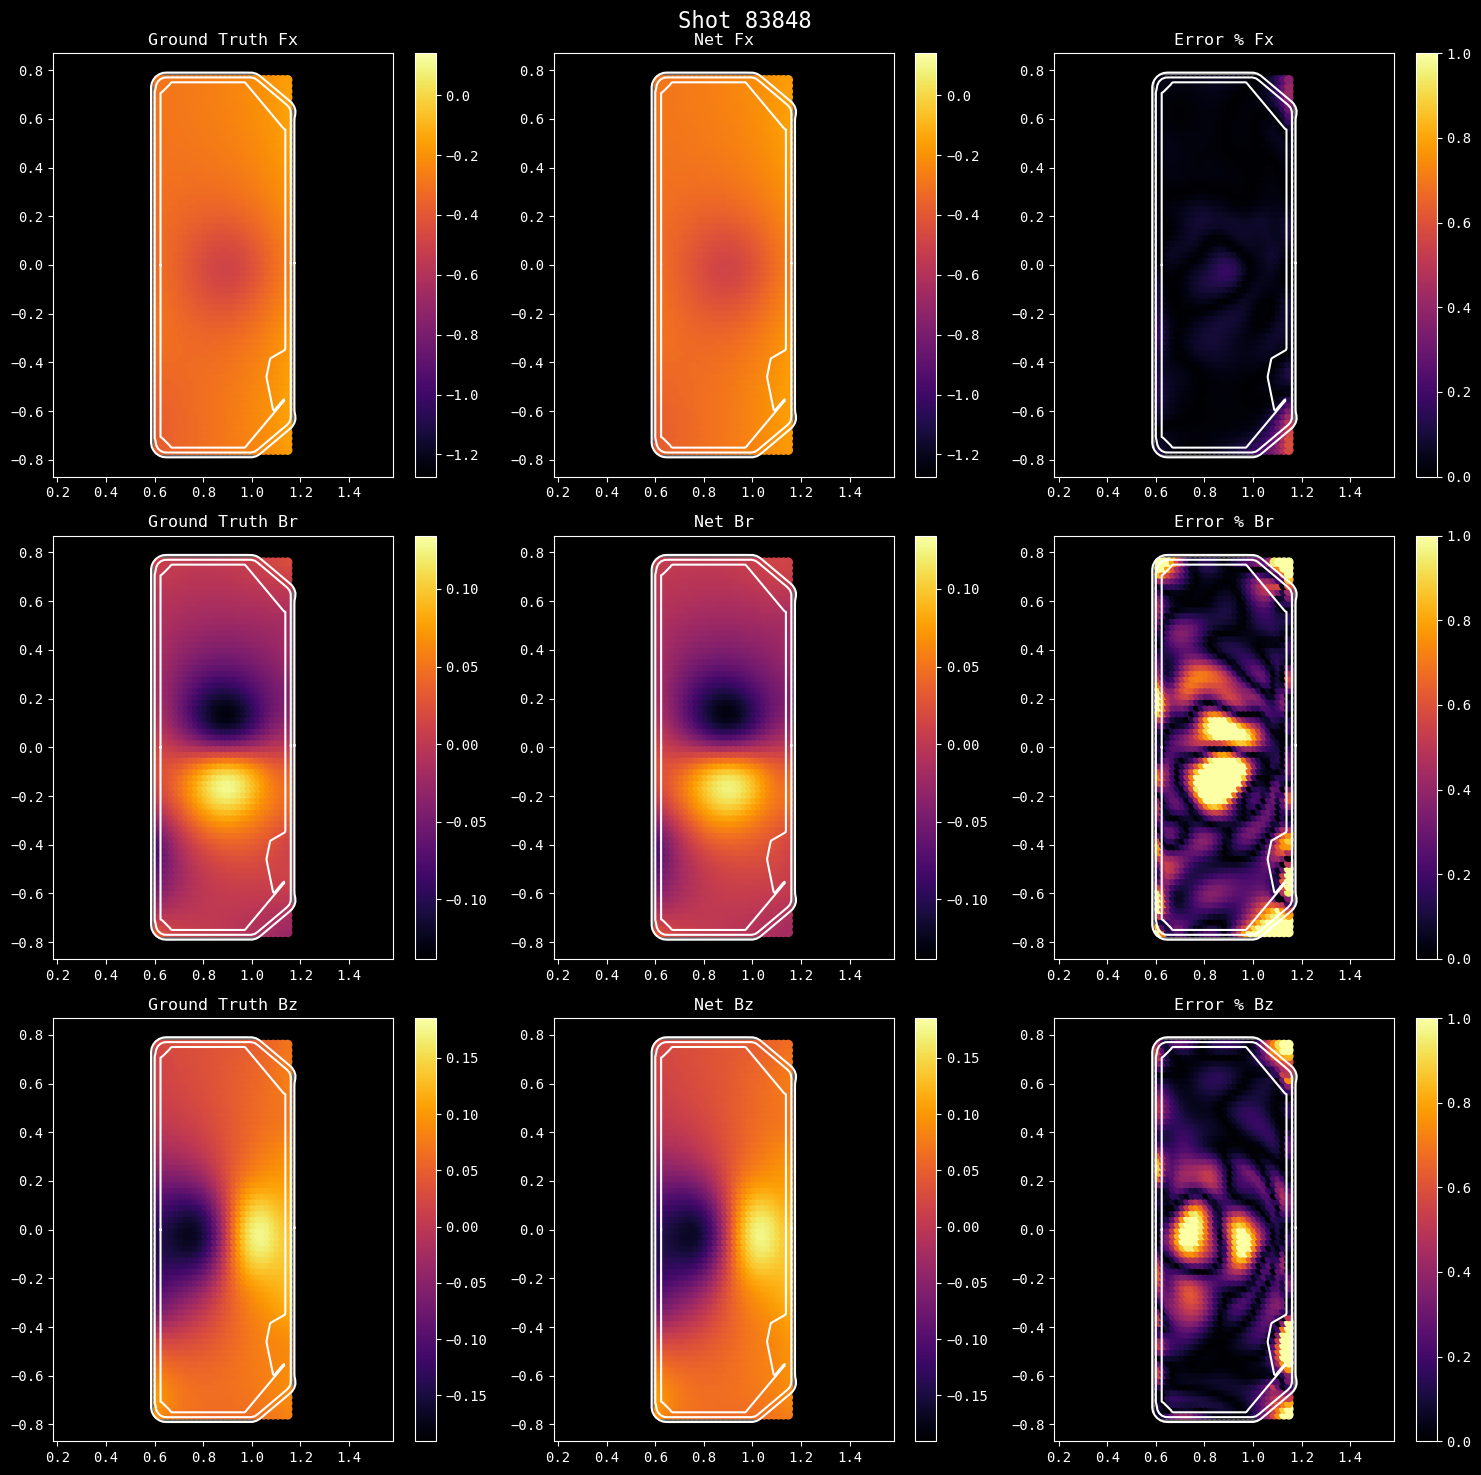

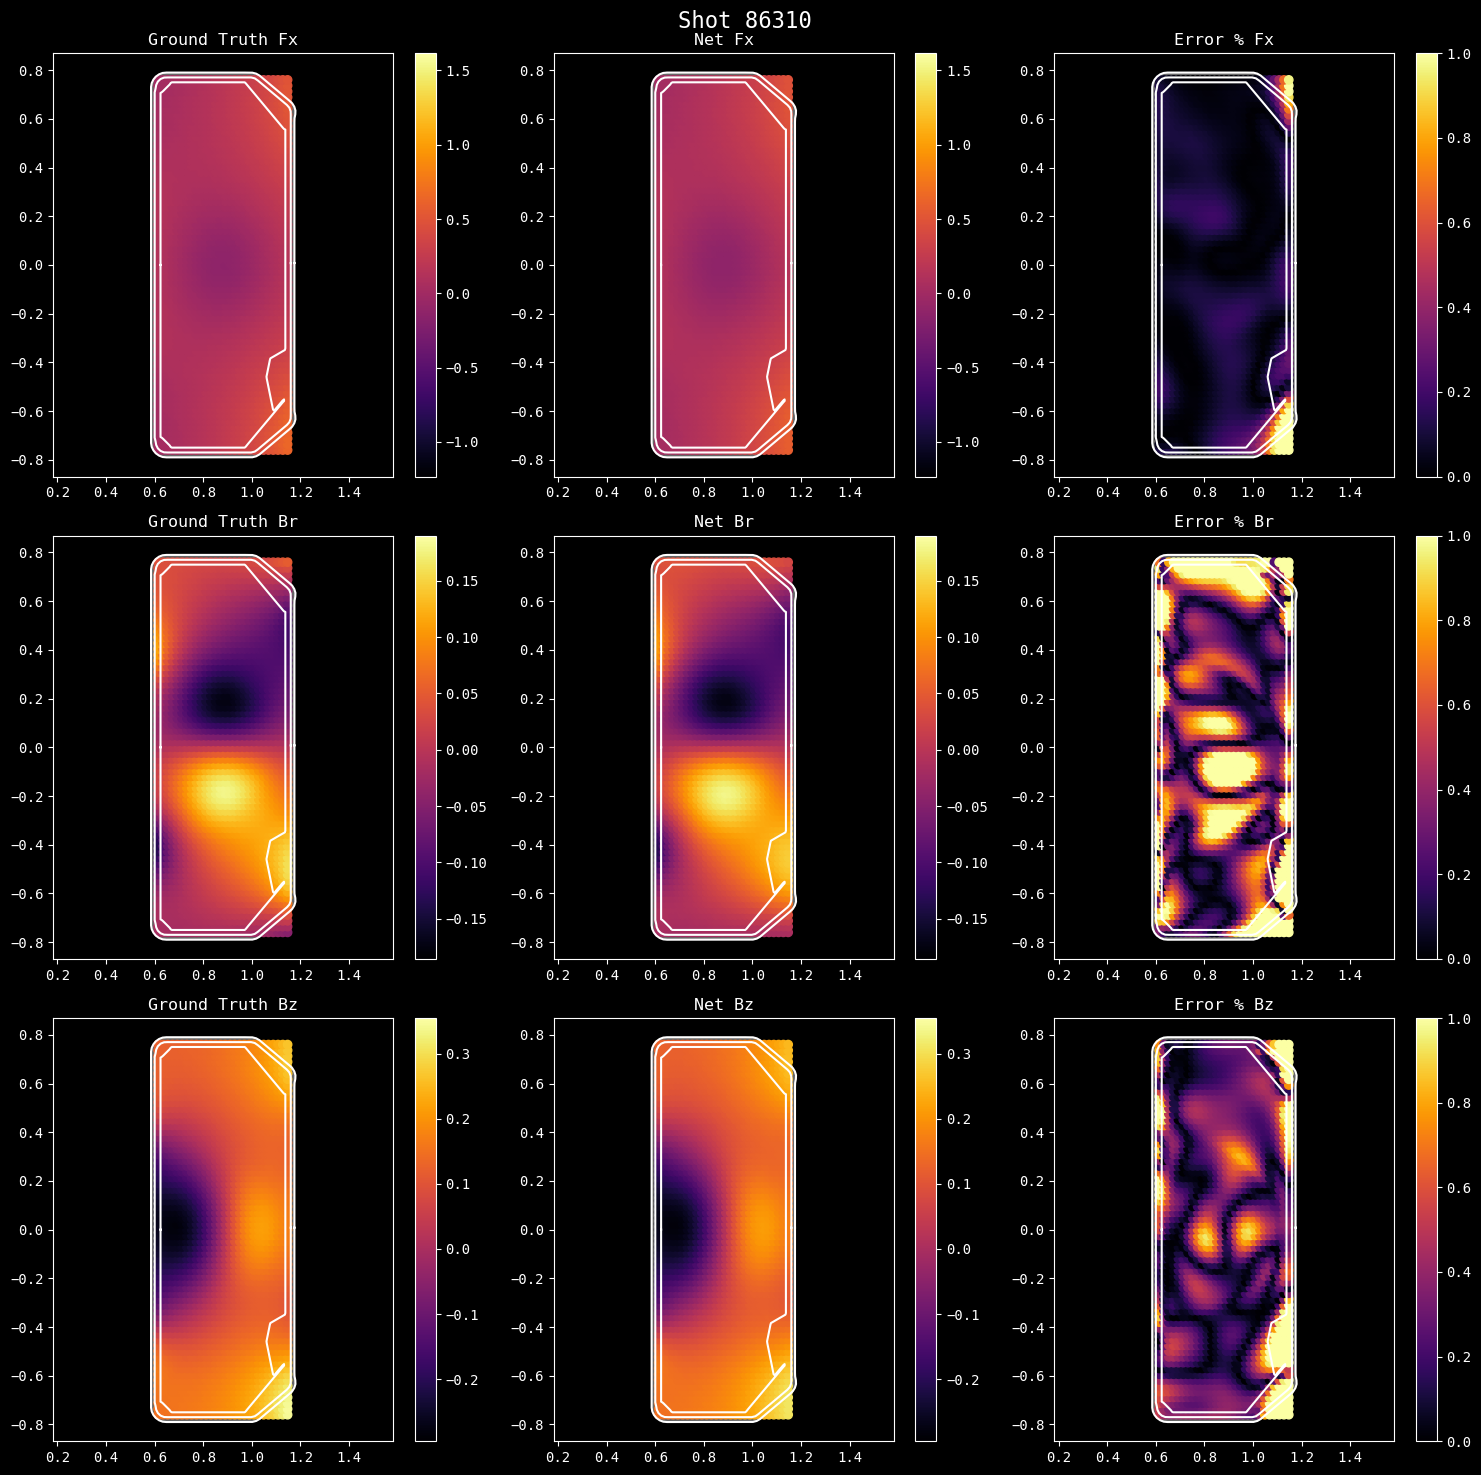

In [4]:
# plotting time baby
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_vessel

g = loadmat('tcv_params/grid.mat')
r, z = g['r'].flatten(), g['z'].flatten()
rr, zz = np.meshgrid(r, z)
rr, zz = rr.flatten(), zz.flatten()

for s, sn in zip(SHOT_FILES, SHOT_NAMES):
    # load
    gt = loadmat(join(SHOTS_DIR, s))
    net = loadmat(join(SHOTS_NET_DIR, f'{sn}_net.mat'))

    ri = 1000

    gFx = gt['Fx']
    gBr = gt['Br']
    gBz = gt['Bz']

    nFx = net['Fx']
    nBr = net['Br']
    nBz = net['Bz']

    # range
    mFx, MFx = np.min(gFx), np.max(gFx)
    mBr, MBr = np.min(gBr), np.max(gBr) 
    mBz, MBz = np.min(gBz), np.max(gBz) 
    rFx = MFx - mFx
    rBr = MBr - mBr
    rBz = MBz - mBz
    # percentage error 
    eFx = 100*np.abs(gFx - nFx) / rFx
    eBr = 100*np.abs(gBr - nBr) / rBr
    eBz = 100*np.abs(gBz - nBz) / rBz


    plt.figure(figsize=(15, 15))
    plt.subplot(3, 3, 1)
    plot_vessel()
    sc1 = plt.scatter(rr, zz, c=gFx[..., ri], vmin=mFx, vmax=MFx) 
    plt.title('Ground Truth Fx')
    plt.axis('equal'), plt.grid(False)
    plt.colorbar(sc1)
    plt.subplot(3, 3, 2)
    plot_vessel()
    sc2 = plt.scatter(rr, zz, c=nFx[..., ri], vmin=mFx, vmax=MFx)
    plt.title('Net Fx')
    plt.axis('equal'), plt.grid(False)
    plt.colorbar(sc2)
    plt.subplot(3, 3, 3)
    plot_vessel()
    sc3 = plt.scatter(rr, zz, c=eFx[..., ri], vmin=0, vmax=1)
    plt.title('Error % Fx')
    plt.axis('equal'), plt.grid(False)  
    plt.colorbar(sc3)

    plt.subplot(3, 3, 4)
    plot_vessel()
    sc4 = plt.scatter(rr, zz, c=gBr[..., ri], vmin=mBr, vmax=MBr)
    plt.title('Ground Truth Br')
    plt.axis('equal'), plt.grid(False)  
    plt.colorbar(sc4)
    plt.subplot(3, 3, 5)
    plot_vessel()
    sc5 = plt.scatter(rr, zz, c=nBr[..., ri], vmin=mBr, vmax=MBr)
    plt.title('Net Br')
    plt.axis('equal'), plt.grid(False)
    plt.colorbar(sc5)
    plt.subplot(3, 3, 6)
    plot_vessel()
    sc6 = plt.scatter(rr, zz, c=eBr[..., ri], vmin=0, vmax=1)
    plt.title('Error % Br')
    plt.axis('equal'), plt.grid(False)          
    plt.colorbar(sc6)

    plt.subplot(3, 3, 7)
    plot_vessel()
    sc7 = plt.scatter(rr, zz, c=gBz[..., ri], vmin=mBz, vmax=MBz)
    plt.title('Ground Truth Bz')
    plt.axis('equal'), plt.grid(False)
    plt.colorbar(sc7)
    plt.subplot(3, 3, 8)
    plot_vessel()
    sc8 = plt.scatter(rr, zz, c=nBz[..., ri], vmin=mBz, vmax=MBz)
    plt.title('Net Bz')
    plt.axis('equal'), plt.grid(False)
    plt.colorbar(sc8)
    plt.subplot(3, 3, 9)
    plot_vessel()
    sc9 = plt.scatter(rr, zz, c=eBz[..., ri], vmin=0, vmax=1)
    plt.title('Error % Bz')
    plt.axis('equal'), plt.grid(False)
    plt.colorbar(sc9)

    plt.suptitle(f'Shot {sn}', fontsize=16)
    plt.tight_layout()
    plt.show()


In [ ]:
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
from matplotlib.animation import FFMpegWriter

g = loadmat('tcv_params/grid.mat')
r, z = g['r'].flatten(), g['z'].flatten()
rr, zz = np.meshgrid(r, z)
rr, zz = rr.flatten(), zz.flatten()

decimate = 1
max_perc_err = 3
fps = 10.0

for s, sn in zip(SHOT_FILES, SHOT_NAMES):
    # load data
    gt = loadmat(join(SHOTS_DIR, s))
    net = loadmat(join(SHOTS_NET_DIR, f'{sn}_net.mat'))

    gFx = gt['Fx']
    gBr = gt['Br']
    gBz = gt['Bz']
    nFx = net['Fx']
    nBr = net['Br']
    nBz = net['Bz']

    # decimate
    gFx, gBr, gBz, nFx, nBr, nBz = map(lambda x: x[..., ::decimate], (gFx, gBr, gBz, nFx, nBr, nBz))

    # range
    mFx, MFx = np.min(gFx,axis=(0,1)), np.max(gFx, axis=(0, 1))

    mBr, MBr = np.min(gBr), np.max(gBr) 
    mBz, MBz = np.min(gBz), np.max(gBz) 
    rFx = MFx - mFx
    rBr = MBr - mBr
    rBz = MBz - mBz

    # precompute error percentage
    eFx = 100 * np.abs(gFx - nFx) / rFx
    eBr = 100 * np.abs(gBr - nBr) / rBr
    eBz = 100 * np.abs(gBz - nBz) / rBz

    n_frames = gFx.shape[-1]

    fig = plt.figure(figsize=(15, 15))
    axs = [plt.subplot(3, 3, i + 1) for i in range(9)]
    scatters, colorbars = [], []

    # Initial plot setup
    def init():
        for ax in axs:
            ax.clear()
            plot_vessel(ax=ax)
            ax.axis('equal')
            ax.grid(False)

        scatters.append(axs[0].scatter(rr, zz, c=gFx[..., 0]))
        axs[0].set_title('Ground Truth Fx')
        colorbars.append(plt.colorbar(scatters[-1], ax=axs[0]))

        scatters.append(axs[1].scatter(rr, zz, c=nFx[..., 0]))
        axs[1].set_title('Net Fx')
        colorbars.append(plt.colorbar(scatters[-1], ax=axs[1]))

        scatters.append(axs[2].scatter(rr, zz, c=eFx[..., 0], vmin=0, vmax=max_perc_err))
        axs[2].set_title('Error % Fx')
        colorbars.append(plt.colorbar(scatters[-1], ax=axs[2]))

        scatters.append(axs[3].scatter(rr, zz, c=gBr[..., 0], vmin=mBr, vmax=MBr))
        axs[3].set_title('Ground Truth Br')
        plt.colorbar(scatters[-1], ax=axs[3])

        scatters.append(axs[4].scatter(rr, zz, c=nBr[..., 0], vmin=mBr, vmax=MBr))
        axs[4].set_title('Net Br')
        plt.colorbar(scatters[-1], ax=axs[4])

        scatters.append(axs[5].scatter(rr, zz, c=eBr[..., 0], vmin=0, vmax=max_perc_err))
        axs[5].set_title('Error % Br')
        plt.colorbar(scatters[-1], ax=axs[5])

        scatters.append(axs[6].scatter(rr, zz, c=gBz[..., 0], vmin=mBz, vmax=MBz))
        axs[6].set_title('Ground Truth Bz')
        plt.colorbar(scatters[-1], ax=axs[6])

        scatters.append(axs[7].scatter(rr, zz, c=nBz[..., 0], vmin=mBz, vmax=MBz))
        axs[7].set_title('Net Bz')
        plt.colorbar(scatters[-1], ax=axs[7])

        scatters.append(axs[8].scatter(rr, zz, c=eBz[..., 0], vmin=0, vmax=max_perc_err))
        axs[8].set_title('Error % Bz')
        plt.colorbar(scatters[-1], ax=axs[8])

        return scatters

    def update(ri):
        # --- Dynamic vmin/vmax for Fx only
        vmin_gFx = np.min(gFx[..., ri])
        vmax_gFx = np.max(gFx[..., ri])
        vmin_nFx = np.min(nFx[..., ri])
        vmax_nFx = np.max(nFx[..., ri])

        scatters[0].set_array(gFx[..., ri].flatten())
        scatters[0].set_clim(vmin_gFx, vmax_gFx)
        colorbars[0].update_normal(scatters[0])

        scatters[1].set_array(nFx[..., ri].flatten())
        # scatters[1].set_clim(vmin_nFx, vmax_nFx)
        scatters[1].set_clim(vmin_gFx, vmax_gFx)
        colorbars[1].update_normal(scatters[1])

        scatters[2].set_array(eFx[..., ri].flatten())
        # Keep error colorbar fixed from 0 to 1 for clarity

        scatters[3].set_array(gBr[..., ri].flatten())
        scatters[4].set_array(nBr[..., ri].flatten())
        scatters[5].set_array(eBr[..., ri].flatten())
        scatters[6].set_array(gBz[..., ri].flatten())
        scatters[7].set_array(nBz[..., ri].flatten())
        scatters[8].set_array(eBz[..., ri].flatten())

        fig.suptitle(f'Shot {sn} — Frame {ri}/{n_frames}', fontsize=16)
        return scatters

    # Save to MP4 with progress bar
    print(f"Rendering animation for shot {sn}...")
    writer = FFMpegWriter(fps=fps, metadata={'artist': 'MATLAB-to-Python'})

    with tqdm(total=n_frames, desc='Rendering frames', colour='yellow') as pbar:
        def update_with_progress(i):
            artists = update(i)
            pbar.update(1)
            return artists

        anim = FuncAnimation(fig, update_with_progress, init_func=init,
                             frames=n_frames, interval=1000 / fps, blit=False)

        anim.save(f'{sn}_animation.mp4', writer=writer)

    plt.close(fig)


Rendering animation for shot 79742...


Rendering frames:   1%|          | 14/1725 [00:12<26:54,  1.06it/s]